In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Import Data

In [118]:
data = pd.read_csv(r"phoenix_uber_trips.csv")

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Driver Name                  3104 non-null   object 
 1   Phone Number                 0 non-null      float64
 2   Email                        3104 non-null   object 
 3   Date/Time                    3104 non-null   object 
 4   Trip ID                      3104 non-null   object 
 5   Type                         3104 non-null   object 
 6   Base Fare                    2929 non-null   object 
 7   Distance                     2925 non-null   object 
 8   Time                         2929 non-null   object 
 9   Min Fare Supplement          787 non-null    object 
 10  Cancellation                 133 non-null    object 
 11  Tip                          855 non-null    object 
 12  Surge                        551 non-null    object 
 13  Diamond Reward    

## 1a.) First Impressions
At first glance, there are some features with 0 or few non-null values. Sparsely populated features will not be valuable for our prediction purposes. Features with 0 will be deleted. Those with less than 30% null will be evaluated to see if an imputed value of 0 will make sense in the context of this data set.  

There are 3,104 records and 25 total columns. 

There is a mix of categorical and numerical features that can be leveraged; however, it appears that many features that should be numerical (ie. Tip) are 'Object' types. 

# 2. Exploratory Data Analysis

In [121]:
data.head()

,Driver Name,Phone Number,Email,Date/Time,Trip ID,Type,Base Fare,Distance,Time,Min Fare Supplement,...,Promotions,Total,Long Pickup Fee,Optional Insurance,Consecutive Trips Promotion,Share Adjustment,Quest Promotion,Fare Adjustment,Platinum Reward,Cleaning Repairs
0,John Doe,NaN,jd@jd.com,"Thursday, April 18, 2019 10:24 PM",9bce9679-2755-4c90-9689-f2de69c8f817,UberX,$0.30,$0.97,$0.68,$0.68,...,NaN,$2.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,John Doe,NaN,jd@jd.com,"Thursday, April 18, 2019 9:48 PM",bb83ec2b-fd4c-457d-ae92-0a216624d85b,UberX,$0.30,$4.10,$2.09,NaN,...,NaN,$9.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,John Doe,NaN,jd@jd.com,"Friday, April 19, 2019 8:39 PM",42450298-7f34-4f5b-8283-3415fe7f15a0,UberX,$0.30,$4.40,$1.79,NaN,...,NaN,$6.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,John Doe,NaN,jd@jd.com,"Friday, April 19, 2019 10:50 PM",6d5371a9-806f-4949-b506-edfffd985ff6,UberX,$0.30,$1.11,$0.60,$0.62,...,NaN,$2.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John Doe,NaN,jd@jd.com,"Wednesday, April 17, 2019 8:08 PM",aaa4e703-53af-4b54-ae35-314684a1e330,UberX,$0.30,$1.10,$0.69,$0.54,...,NaN,$7.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop some columns that do not contain information 

In [125]:
null_columns = data.columns[data.isnull().all()]

In [126]:
data_1 = data.drop(columns=null_columns).copy()

## 2a.) Evaluate Categorical Features

In [132]:
obj_col = data_1.select_dtypes([object]).columns

In [134]:
data_1[obj_col].describe()

,Driver Name,Email,Date/Time,Trip ID,Type,Base Fare,Distance,Time,Min Fare Supplement,Cancellation,Tip,Surge,Diamond Reward,Wait Time,Total,Long Pickup Fee,Optional Insurance,Share Adjustment,Fare Adjustment,Platinum Reward
count,3104,3104,3104,3104,3104,2929,2925,2929,787,133,855,551,1470,576,3104,26,476,7,4,432
unique,1,1,3053,3054,1,1,998,428,185,4,59,51,133,114,1221,25,88,7,3,58
top,John Doe,jd@jd.com,"Sunday, June 23, 2019 10:09 PM",f2d5fcf0-cbe8-4946-983f-e2f0e9f276b8,UberX,$0.30,$1.33,$0.83,$0.29,$3.75,$1.00,$1.25,$0.11,$0.02,$3.75,$0.20,-$0.10,$6.87,-$2.62,$0.04
freq,3104,3104,2,2,3104,2929,20,31,12,117,256,53,62,24,125,2,30,1,2,36


### EDA - Categorical Observations
There is one unique Driver Name, Email and Ride Type - this illustrates that this dataset is specific to a single driver. This means that any predictions are specific to this particular driver and not applicable to all Uber drivers in Arizona. 

In addition, there are some features that should be converted to numerical features (ie. Distance, Time, Cancellation, Tip etc.) 

## 2b.) Convert dollar amounts to floats

In [175]:
to_convert = ['Base Fare', 'Distance', 'Time', 'Min Fare Supplement', 'Cancellation', 'Tip', 'Surge', 'Diamond Reward', 
             'Wait Time', 'Total', 'Long Pickup Fee', 'Optional Insurance', 'Share Adjustment', 'Platinum Reward','Fare Adjustment']

In [176]:
data_2 = data_1.copy()

In [177]:
for col in to_convert: 
    data_2[col] = data_2[col].apply(lambda x:float(str(x).replace("$","")))

## 2c.) EDA - Numerical Features

In [178]:
data_2[to_convert].describe()

,Base Fare,Distance,Time,Min Fare Supplement,Cancellation,Tip,Surge,Diamond Reward,Wait Time,Total,Long Pickup Fee,Optional Insurance,Share Adjustment,Platinum Reward,Fare Adjustment
count,2.929000e+03,2925.000000,2929.000000,787.000000,133.000000,855.000000,551.000000,1470.000000,576.000000,3104.000000,26.000000,476.000000,7.000000,432.000000,4.00000
mean,3.000000e-01,4.100215,1.565278,0.791156,3.781429,2.772409,3.194574,0.346551,0.328368,7.543756,0.887692,-0.246765,5.065714,0.170324,-2.53250
std,1.432432e-14,3.888657,1.000972,0.497893,0.121176,2.075906,2.574347,0.293181,0.316521,5.810466,0.942415,0.233449,2.003371,0.140478,3.61441
min,3.000000e-01,0.010000,0.020000,0.010000,3.750000,0.010000,0.780000,0.030000,0.010000,-6.870000,0.020000,-1.500000,2.520000,0.010000,-6.87000
25%,3.000000e-01,1.370000,0.820000,0.380000,3.750000,1.000000,1.750000,0.140000,0.100000,3.670000,0.220000,-0.322500,3.785000,0.070000,-3.68250
50%,3.000000e-01,2.810000,1.320000,0.740000,3.750000,2.000000,2.500000,0.260000,0.230000,5.740000,0.535000,-0.175000,3.950000,0.120000,-2.62000
75%,3.000000e-01,5.410000,2.080000,1.170000,3.750000,3.000000,4.000000,0.450000,0.470000,9.390000,0.982500,-0.080000,7.015000,0.240000,-1.47000
max,3.000000e-01,28.320000,9.180000,2.300000,4.800000,25.000000,24.770000,2.060000,1.780000,62.470000,3.520000,-0.020000,7.390000,0.760000,1.98000


### 2ci.) Numerical Feature Spread

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1675303015.py:3: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1675303015.py:7: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



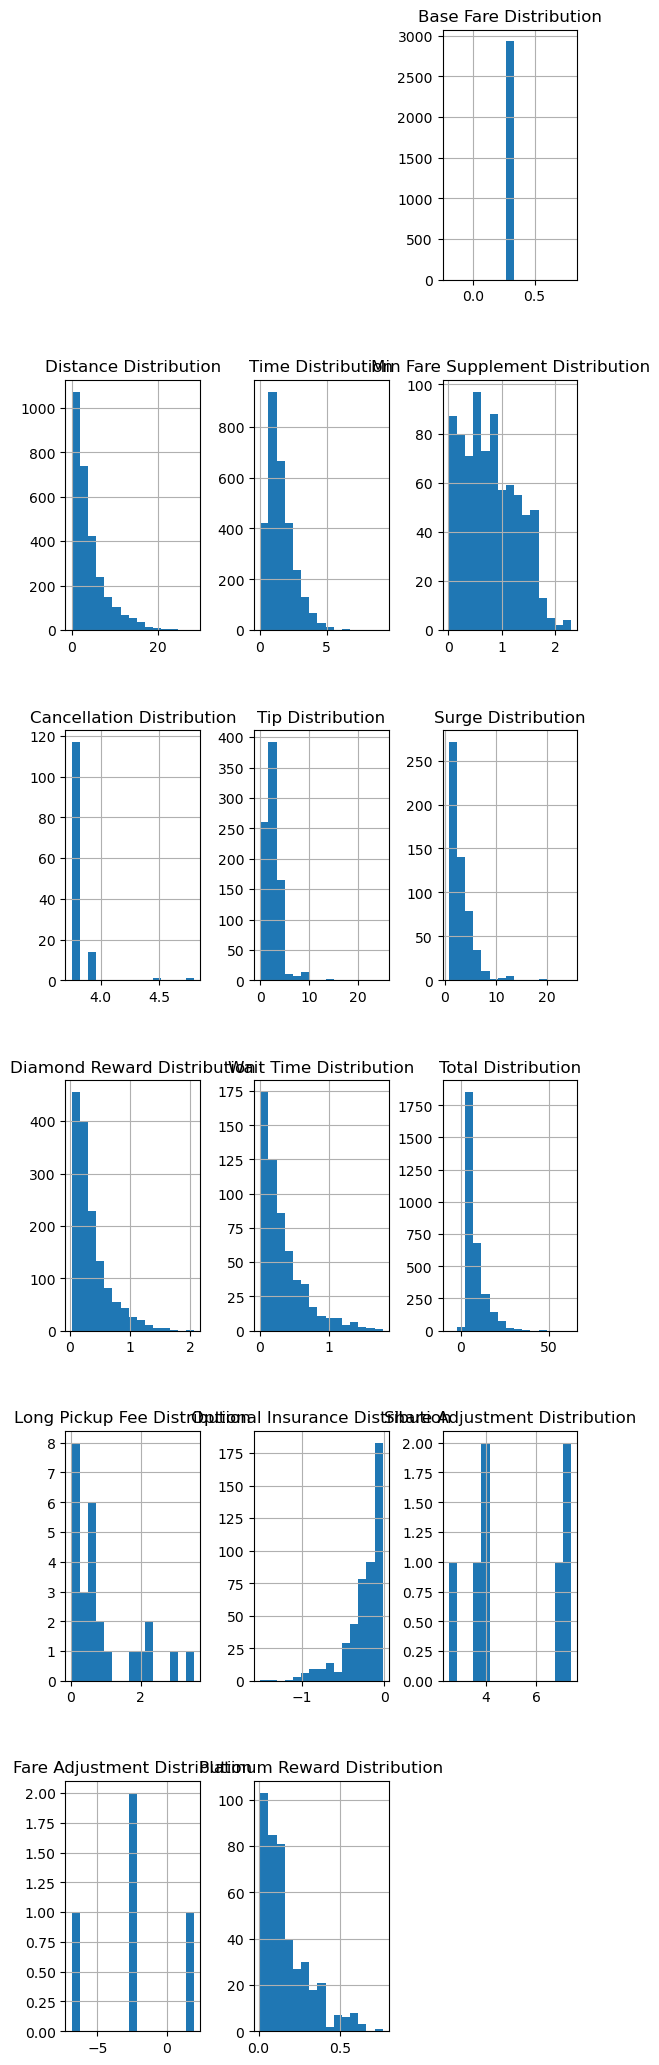

In [179]:
fig=plt.figure()
for i, col in enumerate(data_2):
    if data_2[col].dtype == np.number:
        ax=fig.add_subplot(7,3,i+1)
        data_2[col].hist(bins=15,ax=ax)
        ax.set_title(col+" Distribution")
fig.tight_layout(pad=5.0)  # Improves appearance a bit.

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=5,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

#### EDA - Numerical Features Observations 
It appears that there is little variation in the Base Fare. We may remove this feature. 


### 2ci.) Numerical Feature Relationships

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1142535116.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

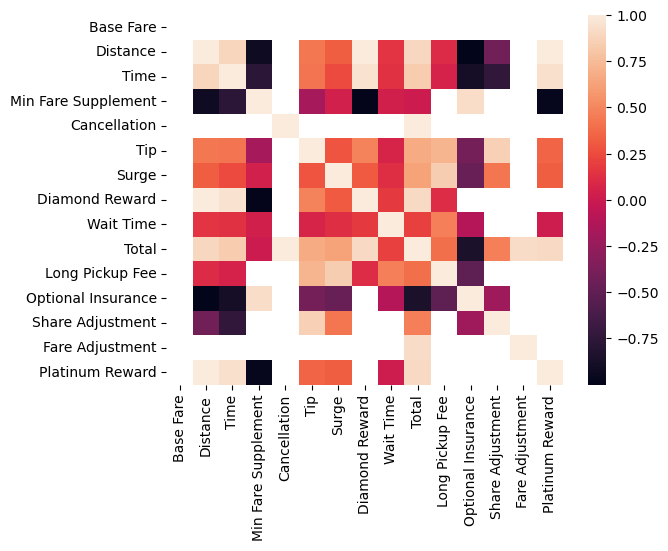

In [180]:
sns.heatmap(data_2.corr())

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/399674987.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




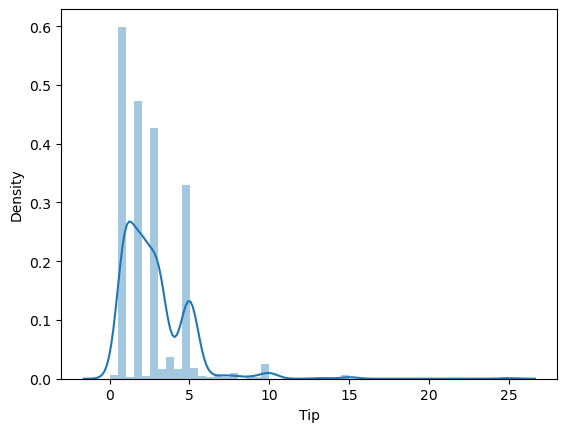

In [181]:
sns.distplot(data_2['Tip']);

Interesting little spikes around 5, 10 and 15! Could be due to the eveness of these number values so that individuals are more likely to tip around that or round up to those values.

Gotta take out any outliers

In [731]:
# data_3 = data_2.drop(columns='Cancellation').copy()
data_3 = data_2.copy()

### Fill NA Tip with 0 - assuming equivalence to no tip 

In [732]:
data_3['Tip'] = data_3['Tip'].fillna(0)
data_3['Min Fare Supplement'] = data_3['Min Fare Supplement'].fillna(0)
data_3['Surge'] = data_3['Surge'].fillna(0)
data_3['Diamond Reward'] = data_3['Diamond Reward'].fillna(0)
data_3['Wait Time'] = data_3['Wait Time'].fillna(0)
data_3['Long Pickup Fee'] = data_3['Long Pickup Fee'].fillna(0)
data_3['Share Adjustment'] = data_3['Share Adjustment'].fillna(0)
data_3['Platinum Reward'] = data_3['Platinum Reward'].fillna(0)
data_3['Optional Insurance'] = data_3['Optional Insurance'].fillna(0)
data_3['Fare Adjustment'] = data_3['Fare Adjustment'].fillna(0)

In [733]:
data_3['Tip perc'] = data_3['Tip']/data_3['Total']

In [734]:
# tip outliers 
tip_q3, tip_q1 = np.percentile(data_3['Tip perc'].dropna(), [75 ,25])
iqr = tip_q3 - tip_q1
outlier_thresh = (1.5*iqr)+tip_q3
outlier_thresh

0.31796512022658274

Since there are about 300 records where the Tip is greater than 2.5, I will start with removing the biggest outliers - tips around 14

(array([40., 91., 80., 70., 68., 15., 15.,  0.,  0., 12.]),
 array([0.09787928, 0.18809135, 0.27830343, 0.3685155 , 0.45872757,
        0.54893964, 0.63915171, 0.72936378, 0.81957586, 0.90978793,
        1.        ]),
 <BarContainer object of 10 artists>)

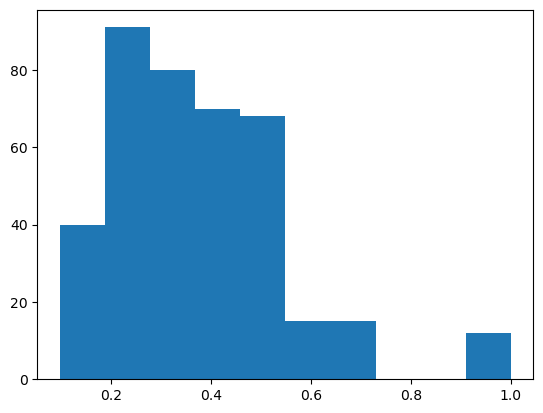

In [735]:
plt.hist(data_3[data_3['Tip']>2.5]['Tip perc'])

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1751014658.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



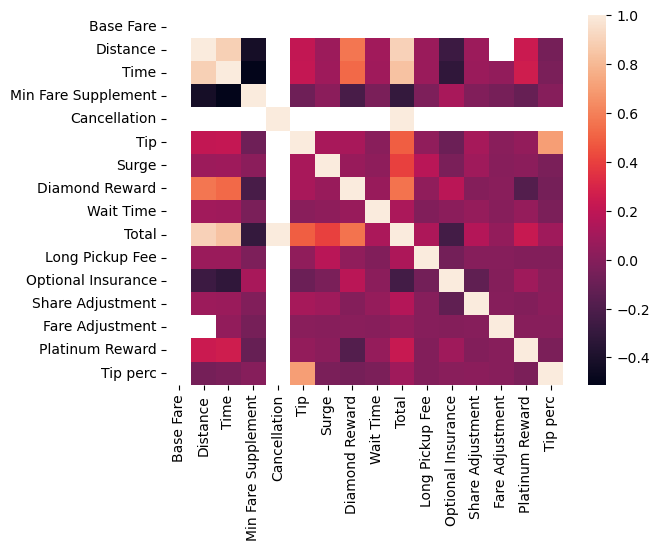

In [736]:
sns.heatmap(data_3.corr());

Distance, Time and Total appear strongly positively correlated to one another

In [737]:
# num_features = data_3.select_dtypes([np.number]).columns
# fig = px.scatter_matrix(data_3[num_features],width=1000, height=1000)
# fig.show()

In [738]:
print("Numerical Feature Correlations to Tip Percent")
data_3.corr()['Tip perc']

Numerical Feature Correlations to Tip Percent


/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/4125835380.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Base Fare                   NaN
Distance              -0.056717
Time                  -0.041406
Min Fare Supplement    0.002023
Cancellation                NaN
Tip                    0.701523
Surge                 -0.040286
Diamond Reward        -0.059278
Wait Time             -0.036479
Total                  0.090070
Long Pickup Fee       -0.012554
Optional Insurance     0.010251
Share Adjustment       0.015124
Fare Adjustment        0.006116
Platinum Reward       -0.036465
Tip perc               1.000000
Name: Tip perc, dtype: float64

In [739]:
print("Numerical Feature Correlations to Tip Percent")
data_3.corr()['Tip']

Numerical Feature Correlations to Tip Percent


/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1679836594.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Base Fare                   NaN
Distance               0.212546
Time                   0.220715
Min Fare Supplement   -0.081732
Cancellation                NaN
Tip                    1.000000
Surge                  0.116250
Diamond Reward         0.117899
Wait Time              0.012390
Total                  0.490509
Long Pickup Fee        0.032258
Optional Insurance    -0.096788
Share Adjustment       0.108799
Fare Adjustment        0.010458
Platinum Reward        0.043956
Tip perc               0.701523
Name: Tip, dtype: float64

In [629]:
print("Numerical Feature Correlations to Total")
data_3.corr()['Total']

Numerical Feature Correlations to Total


/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/2971680019.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Base Fare                   NaN
Distance               0.901488
Time                   0.842910
Min Fare Supplement   -0.307529
Cancellation           1.000000
Tip                    0.465106
Surge                  0.377204
Diamond Reward         0.551730
Wait Time              0.127679
Total                  1.000000
Long Pickup Fee        0.138757
Optional Insurance    -0.245373
Share Adjustment       0.163931
Fare Adjustment        0.049985
Platinum Reward        0.232185
Name: Total, dtype: float64

#### Features to drop 
The following features are highly correlated to "Total":
- Distance
- Time

Suggests that the Total is constructed from other features - so we will drop "Total"

We also drop fields that have no relationship to Tip (Base Fare and Cancellation)

Driver Name, Email and Type will also be dropped as they serve no purpose to prediciton

There is so little correlation to the dependent variable, we will try to convert some of the fields to binary

In [740]:
no_relationship_col = ['Base Fare', 'Cancellation', 'Total']

In [741]:
data_4 = data_3.drop(columns=no_relationship_col).copy()
# dropping the following features as there is only 1 unique value
data_4 = data_4.drop(columns = ['Driver Name', 'Email','Type'])

In [742]:
data_4.head()

,Date/Time,Trip ID,Distance,Time,Min Fare Supplement,Tip,Surge,Diamond Reward,Wait Time,Long Pickup Fee,Optional Insurance,Share Adjustment,Fare Adjustment,Platinum Reward,Tip perc
0,"Thursday, April 18, 2019 10:24 PM",9bce9679-2755-4c90-9689-f2de69c8f817,0.97,0.68,0.68,0.0,0.0,0.10,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
1,"Thursday, April 18, 2019 9:48 PM",bb83ec2b-fd4c-457d-ae92-0a216624d85b,4.10,2.09,0.00,3.0,0.0,0.37,0.00,0.0,0.0,0.0,0.0,0.0,0.304260
2,"Friday, April 19, 2019 8:39 PM",42450298-7f34-4f5b-8283-3415fe7f15a0,4.40,1.79,0.00,0.0,0.0,0.38,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
3,"Friday, April 19, 2019 10:50 PM",6d5371a9-806f-4949-b506-edfffd985ff6,1.11,0.60,0.62,0.0,0.0,0.11,0.23,0.0,0.0,0.0,0.0,0.0,0.000000
4,"Wednesday, April 17, 2019 8:08 PM",aaa4e703-53af-4b54-ae35-314684a1e330,1.10,0.69,0.54,5.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0.0,0.645995


# 3. Baby Feature Engineering
We will construct some new features from the Date/Time field. 
- Day of Week 
- Date 
- Morning, Noon, Evening categorizations 
- Time of Day

In [743]:
data_4['Day of Week'] = data_4['Date/Time'].apply(lambda x:str(x)[:str(x).index(',')])

In [744]:
data_4['date'] = data_4['Date/Time'].apply(lambda x:pd.to_datetime(x))
data_4['hour'] = data_4['date'].apply(lambda x:x.hour)
data_4['time'] = data_4['date'].apply(lambda x:x.timestamp)
data_4['month'] = data_4['date'].apply(lambda x:x.month)
data_4['month day'] = data_4['date'].apply(lambda x:x.day)

In [745]:
data_4['weekend'] = data_4['Day of Week'].apply(lambda x:1 if x in ['Saturday','Sunday'] else 0)
data_4['weekday'] = data_4['Day of Week'].apply(lambda x:1 if x not in ['Saturday','Sunday'] else 0)

In [746]:
# morning
def time_of_day(row):
    if row['hour'] >= 0 and row['hour']< 5:
        return 'Early Morning'
    elif row['hour']>= 5 and row['hour']< 12:
        return 'Morning'
    elif row['hour']>= 12 and row['hour']< 19:
        return 'Afternoon'
    elif row['hour']>=19 and row['hour'] < 24:
        return 'Evening'
    else:
        return 'Invalid'
data_4['time_of_day'] = data_4.apply(lambda x:time_of_day(x),axis=1)

In [747]:
data_4.head()

,Date/Time,Trip ID,Distance,Time,Min Fare Supplement,Tip,Surge,Diamond Reward,Wait Time,Long Pickup Fee,...,Tip perc,Day of Week,date,hour,time,month,month day,weekend,weekday,time_of_day
0,"Thursday, April 18, 2019 10:24 PM",9bce9679-2755-4c90-9689-f2de69c8f817,0.97,0.68,0.68,0.0,0.0,0.10,0.00,0.0,...,0.000000,Thursday,2019-04-18 22:24:00,22,<built-in method timestamp of Timestamp object...,4,18,0,1,Evening
1,"Thursday, April 18, 2019 9:48 PM",bb83ec2b-fd4c-457d-ae92-0a216624d85b,4.10,2.09,0.00,3.0,0.0,0.37,0.00,0.0,...,0.304260,Thursday,2019-04-18 21:48:00,21,<built-in method timestamp of Timestamp object...,4,18,0,1,Evening
2,"Friday, April 19, 2019 8:39 PM",42450298-7f34-4f5b-8283-3415fe7f15a0,4.40,1.79,0.00,0.0,0.0,0.38,0.00,0.0,...,0.000000,Friday,2019-04-19 20:39:00,20,<built-in method timestamp of Timestamp object...,4,19,0,1,Evening
3,"Friday, April 19, 2019 10:50 PM",6d5371a9-806f-4949-b506-edfffd985ff6,1.11,0.60,0.62,0.0,0.0,0.11,0.23,0.0,...,0.000000,Friday,2019-04-19 22:50:00,22,<built-in method timestamp of Timestamp object...,4,19,0,1,Evening
4,"Wednesday, April 17, 2019 8:08 PM",aaa4e703-53af-4b54-ae35-314684a1e330,1.10,0.69,0.54,5.0,0.0,0.11,0.00,0.0,...,0.645995,Wednesday,2019-04-17 20:08:00,20,<built-in method timestamp of Timestamp object...,4,17,0,1,Evening


In [748]:
data_4.columns

Index(['Date/Time', 'Trip ID', 'Distance', 'Time', 'Min Fare Supplement',
       'Tip', 'Surge', 'Diamond Reward', 'Wait Time', 'Long Pickup Fee',
       'Optional Insurance', 'Share Adjustment', 'Fare Adjustment',
       'Platinum Reward', 'Tip perc', 'Day of Week', 'date', 'hour', 'time',
       'month', 'month day', 'weekend', 'weekday', 'time_of_day'],
      dtype='object')

In [767]:
# we choose not to include share adjustment, fare adjustment or min fare supplement as those may have negative numbers
to_binary = ['Diamond Reward', 'Wait Time', 'Long Pickup Fee', 'Optional Insurance', 'Platinum Reward', 'Tip']

In [768]:
for col in to_binary:
    new_col = 'Binary ' + col
    data_4[new_col] = data_4[col].apply(lambda x:1 if x> 0 else 0)

## 3a.) Encode Categorical Values

We will choose one hot encoding for the categorical day values. This may explode the number of features, but will be a more accurate representation of the feature values, as label encoding implies a ranking due to the nature of encoding. 

In [754]:
from sklearn.preprocessing import OneHotEncoder

In [755]:
onehot_encoder = OneHotEncoder()

In [769]:
day_of_week_encoded_df = pd.DataFrame(onehot_encoder.fit_transform(data_4[['Day of Week']]).toarray())
day_of_week_encoded_df.columns = onehot_encoder.get_feature_names_out(['Day of Week'])

In [770]:
time_of_day_encoded_df = pd.DataFrame(onehot_encoder.fit_transform(data_4[['time_of_day']]).toarray())
time_of_day_encoded_df.columns = onehot_encoder.get_feature_names_out(['time_of_day'])

In [771]:
data_5 = data_4.copy()

In [772]:
data_5 = data_4.join(day_of_week_encoded_df)

In [773]:
data_5 = data_5.join(time_of_day_encoded_df)

In [774]:
data_5.head()

,Date/Time,Trip ID,Distance,Time,Min Fare Supplement,Tip,Surge,Diamond Reward,Wait Time,Long Pickup Fee,...,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,time_of_day_Afternoon,time_of_day_Early Morning,time_of_day_Evening,time_of_day_Morning
0,"Thursday, April 18, 2019 10:24 PM",9bce9679-2755-4c90-9689-f2de69c8f817,0.97,0.68,0.68,0.0,0.0,0.10,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,"Thursday, April 18, 2019 9:48 PM",bb83ec2b-fd4c-457d-ae92-0a216624d85b,4.10,2.09,0.00,3.0,0.0,0.37,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,"Friday, April 19, 2019 8:39 PM",42450298-7f34-4f5b-8283-3415fe7f15a0,4.40,1.79,0.00,0.0,0.0,0.38,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,"Friday, April 19, 2019 10:50 PM",6d5371a9-806f-4949-b506-edfffd985ff6,1.11,0.60,0.62,0.0,0.0,0.11,0.23,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,"Wednesday, April 17, 2019 8:08 PM",aaa4e703-53af-4b54-ae35-314684a1e330,1.10,0.69,0.54,5.0,0.0,0.11,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Drop the unnecessary columns of Day of Week and Time of Day

In [775]:
data_5 = data_5.drop(columns=["Day of Week", "time_of_day", "Trip ID", "Date/Time"])

# Re-Check Relationships

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/2630850599.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

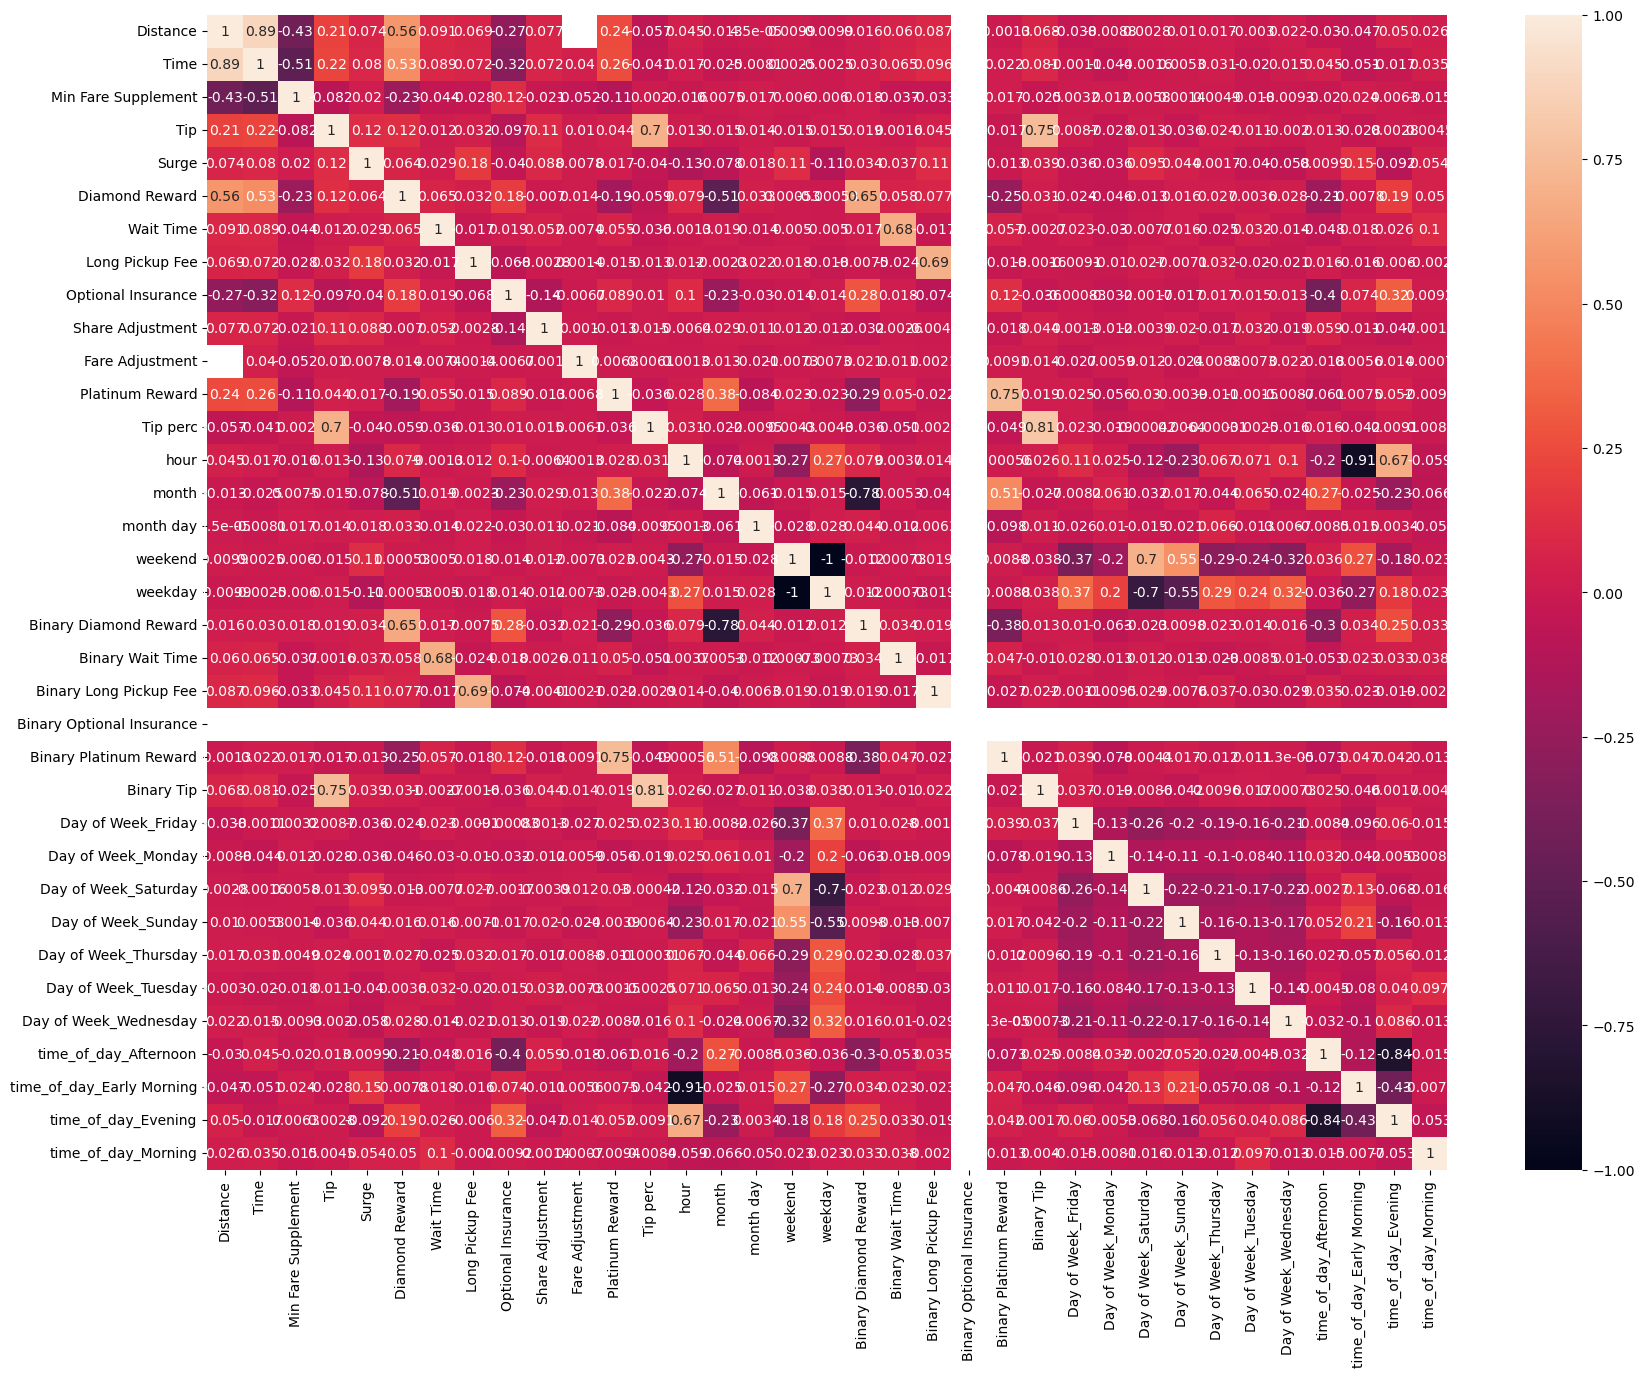

In [776]:
plt.figure(figsize=(20,15))
sns.heatmap(data_5.corr(),annot=True)

In [796]:
data_4['Binary Tip'].value_counts()

0    2249
1     855
Name: Binary Tip, dtype: int64

In [777]:
data_5.corr()['Binary Tip']

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/1788754402.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Distance                     0.068091
Time                         0.081071
Min Fare Supplement         -0.024591
Tip                          0.751030
Surge                        0.039227
Diamond Reward               0.031091
Wait Time                   -0.002661
Long Pickup Fee             -0.001586
Optional Insurance          -0.036468
Share Adjustment             0.044472
Fare Adjustment              0.013925
Platinum Reward              0.019138
Tip perc                     0.807356
hour                         0.026118
month                       -0.027122
month day                    0.010623
weekend                     -0.038423
weekday                      0.038423
Binary Diamond Reward        0.013124
Binary Wait Time            -0.010499
Binary Long Pickup Fee       0.022458
Binary Optional Insurance         NaN
Binary Platinum Reward      -0.020824
Binary Tip                   1.000000
Day of Week_Friday           0.037020
Day of Week_Monday          -0.019297
Day of Week_

Filtering based on correlation does not give us many options. So we will investigate a wrapper method

In [778]:
data_5 = data_5.drop(columns=['time','date'])

Drop records where the distance and/or time is null as these records suggest that no trip happened.

In [779]:
data_6 = data_5.dropna(axis=0, subset=['Time'])
data_6 = data_5.dropna(axis=0, subset=['Distance'])

In [780]:
data_6['Distance'] = data_6['Distance'].fillna(0)

/var/folders/fz/t2vzjc0972z84q18tt4k4pph0000gn/T/ipykernel_5683/2059828489.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 4. Feature Selection - Wrapper Method

We will use the Grid search

In [793]:
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [782]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import lightgbm as ltb

In [673]:
data_6.columns

Index(['Distance', 'Time', 'Min Fare Supplement', 'Tip', 'Surge',
       'Diamond Reward', 'Wait Time', 'Long Pickup Fee', 'Optional Insurance',
       'Share Adjustment', 'Fare Adjustment', 'Platinum Reward', 'hour',
       'month', 'month day', 'weekend', 'weekday', 'Day of Week_Friday',
       'Day of Week_Monday', 'Day of Week_Saturday', 'Day of Week_Sunday',
       'Day of Week_Thursday', 'Day of Week_Tuesday', 'Day of Week_Wednesday',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Morning'],
      dtype='object')

## 4a.) Feature Scaling

In [674]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

model_data = data_6.copy()
target = model_data['Tip']
X_train, X_test, y_train, y_test = train_test_split(
    model_data,
    target,
    test_size=0.2,
    random_state=42)

model_data = model_data.drop(columns=['Tip'])
to_scale = ['Distance', 'Time', 'Min Fare Supplement', 'Surge',
       'Diamond Reward', 'Wait Time', 'Long Pickup Fee', 'Optional Insurance',
       'Share Adjustment', 'Fare Adjustment', 'Platinum Reward'] # non-categorical models 
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.fit_transform(X_test[to_scale])
model_data[to_scale] = scaler.fit_transform(model_data[to_scale])

In [675]:
columns = model_data.columns

## 4b.) Grid Search

In [676]:
lgbm= GridSearchCV(ltb.LGBMRegressor(), parameters, scoring='neg_mean_squared_error',cv=10)

In [677]:
lgbm_best_est = lgbm.fit(model_data, target)
lgbm_best_est.best_estimator_.feature_importances_

array([591, 636,  42, 223, 245, 146,  11, 112,   0,   0,  73, 220, 166,
       311,  57,   0,  26,  13,  24,  11,  20,  13,  16,  15,   1,  28,
         0], dtype=int32)

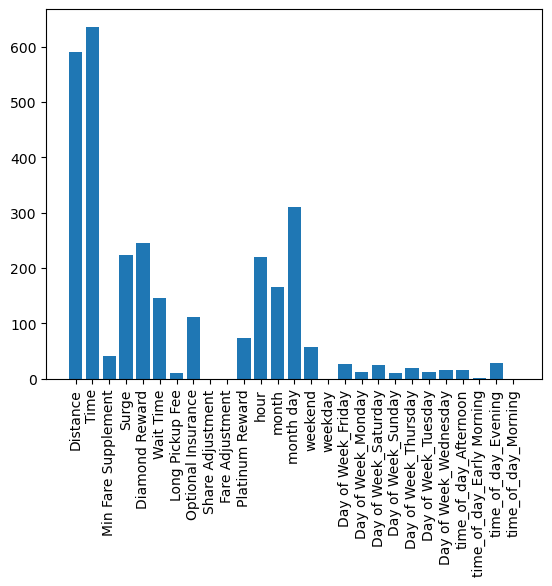

In [678]:
lgbm_importances = lgbm_best_est.best_estimator_.feature_importances_
plt.bar([x for x in columns], lgbm_importances)
plt.xticks(rotation='vertical')
plt.show()

In [679]:
selected_features = ["Distance","Time","Surge","Diamond Reward",
                     "month day"]

# 5. Ridge Regression

## 5a.) Hyper-Param Tuning

In [680]:
parameters = {'alpha':[1, 10]}

In [681]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [682]:
ridge = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error',cv=10)

In [683]:
training_model = ridge.fit(X_train, y_train)

In [684]:
# best param
best_param = ridge_gscv.best_params_
best_param

{'alpha': 10}

In [685]:
best_model = training_model.best_estimator_

In [686]:
# best_model.fit(model_data,target)

In [687]:
predictions = best_model.predict(X_test)

In [688]:
mae = mean_absolute_error(y_test, predictions)

In [689]:
print(mae)

1.0603247288251259


(array([247., 180.,  76.,  49.,  21.,   5.,   4.,   1.,   1.,   2.]),
 array([0.26210222, 0.58744555, 0.91278887, 1.23813219, 1.56347552,
        1.88881884, 2.21416216, 2.53950549, 2.86484881, 3.19019213,
        3.51553545]),
 <BarContainer object of 10 artists>)

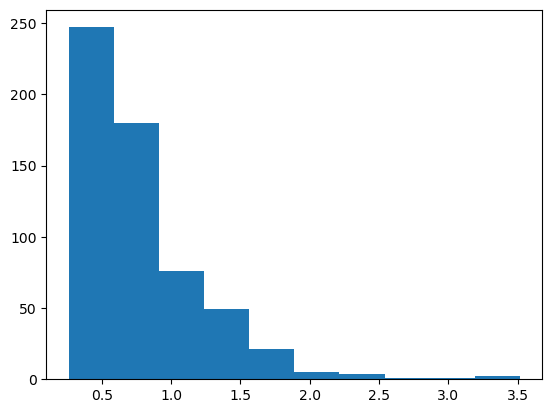

In [608]:
plt.hist(predictions)

This is best results I could achieve with this data. However, this MAE is not good enough

(array([2.359e+03, 1.890e+02, 1.870e+02, 2.200e+01, 1.440e+02, 5.000e+00,
        5.000e+00, 3.000e+00, 1.000e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
        11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
        22.5 , 23.75, 25.  ]),
 <BarContainer object of 20 artists>)

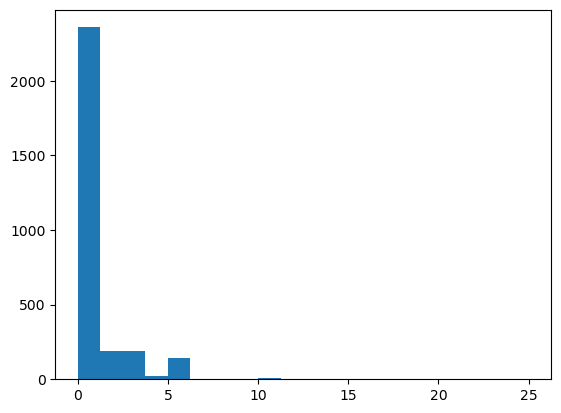

In [606]:
plt.hist(target,bins=20)

# 6. Light GBM Model

In [784]:
lgbm_best_est_train = lgbm.fit(X_train, y_train)
lgbm_best_est_train.best_estimator_.feature_importances_

array([984, 894, 255, 365, 502], dtype=int32)

In [785]:
X_train.columns

Index(['Distance', 'Time', 'Surge', 'Diamond Reward', 'month day'], dtype='object')

In [786]:
lgbm_pred = lgbm_best_est_train.predict(X_test)

In [795]:
print(r2_score(y_test, lgbm_pred))
print(mean_absolute_error(y_test, lgbm_pred))

-0.14415114378669736
1.0814831760795007
